In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import json
from data_process import New_Amazon, Amazon_meta
from collections import defaultdict

把两个独立的Amazon数据读进来

In [3]:
domain_A = "Books"
domain_B = "Movies_and_TV"
data_A = New_Amazon(domain_A, 0)
data_B = New_Amazon(domain_B, 0)

0it [00:00, ?it/s]

51311621it [08:37, 99192.69it/s] 
8765568it [01:20, 109460.99it/s]


In [4]:
# 给每个交互添加domain id
new_data_A, new_data_B = [], []
for inter in tqdm(data_A):
    new_inter = list(inter)
    new_inter.append(0)
    new_data_A.append(new_inter)
for inter in tqdm(data_B):
    new_inter = list(inter)
    new_inter.append(1)
    new_data_B.append(new_inter)

100%|██████████| 8765568/8765568 [00:15<00:00, 577460.12it/s] 


1. read_data: 把所有数据读出来，然后存到一个list中
2. filter: 单纯过滤掉交互过小的交互，返回的还是list
3. id_map: 制作user和item的dict映射，并拆掉list，变成一个用户的交互序列

In [5]:
def count_inter(data, t_min, t_max):
    
    user_count = {}
    item_count = {}
    for inter in data:
        user_id, item_id, time, _ = inter
        
        if user_id not in user_count.keys():
            user_count[user_id] = 1
        else:
            if time > t_min and time < t_max:
                user_count[user_id] += 1

        if item_id not in item_count.keys():
            item_count[item_id] = 1
        else:
            if time > t_min and time < t_max:
                item_count[item_id] += 1

    
    return user_count, item_count

In [6]:
def filter(data, user_minmum, item_minimum, t_min=1451577600, t_max=1459440000):   # 过滤掉交互少的数据
    
    user_count, item_count = count_inter(data, t_min=t_min, t_max=t_max)
    domain_set = {0: {"user": [], "item": []},
                  1: {"user": [], "item": []},
                  }
    new_data = []

    for inter in tqdm(data):
        user_id, item_id, time, domain_id = inter
        
        if item_count[item_id] > item_minimum and user_count[user_id] > user_minmum \
           and time > t_min and time < t_max:    # 只取2016-01-01到2016-01-15之间的数据
            
            new_data.append(inter)
            domain_set[domain_id]["user"].append(user_id)
            domain_set[domain_id]["item"].append(item_id)
    
    print("filter done!")

    return new_data, domain_set

In [7]:
def make_sequence(data):

    seq = {}
    domain_seq = {}

    for inter in tqdm(data):
        user_id, item_id, time, domain_id = inter
        if user_id not in seq.keys():
            seq[user_id] = [item_id]
            domain_seq[user_id] = [domain_id]
        else:
            seq[user_id].append(item_id)
            domain_seq[user_id].append(domain_id)

    return seq, domain_seq

In [8]:
def id_map(data, domain_set):
    
    final_data, final_domain = {}, {}
    temp_data = {}
    new_user_id = 1
    temp_item_count = {domain_id: len(set(domain_set[domain_id]["item"])) for domain_id in domain_set.keys()}
    item_count = {0: 1, 1: 1}
    item_dict = {
        0: {"str2id": {}, "id2str": {},},
        1: {"str2id": {}, "id2str": {},},
    }
    user_dict = {"str2id": {}, "id2str": {},}

    for inter in tqdm(data):
        user_id, item_id, time, domain_id = inter
            
        if item_id not in item_dict[domain_id]["str2id"].keys():
            new_item_id = item_count[domain_id]
            item_dict[domain_id]["str2id"][item_id] = new_item_id
            item_dict[domain_id]["id2str"][new_item_id] = item_id
            item_count[domain_id] += 1
        
        if user_id not in user_dict["str2id"].keys():
            user_dict["str2id"][user_id] = new_user_id
            user_dict["id2str"][new_user_id] = user_id
            temp_data[new_user_id] = [(item_dict[domain_id]["str2id"][item_id], domain_id, time)]
            new_user_id += 1
        else:
            temp_data[user_dict["str2id"][user_id]].append((item_dict[domain_id]["str2id"][item_id], domain_id, time))

    print("map done!")

    for user_id, inter in tqdm(temp_data.items()):

        inter.sort(key=lambda x: x[2])
        final_data[user_id] = [temp_tuple[0] for temp_tuple in inter]
        final_domain[user_id] = [temp_tuple[1] for temp_tuple in inter]

    print("sort done!")
    
    return final_data, final_domain, user_dict, item_dict, item_count


In [9]:
# K-core user_core item_core
def check_Kcore(data, user_core, item_core):

    user_count = {}
    item_count = {}
    for inter in data:
        user_id, item_id, time, _ = inter
        
        if user_id not in user_count.keys():
            user_count[user_id] = 1
        else:
            user_count[user_id] += 1

        if item_id not in item_count.keys():
            item_count[item_id] = 1
        else:
            item_count[item_id] += 1

    for _, num in user_count.items():
        if num < user_core:
            return user_count, item_count, False
    for _, num in item_count.items():
        if num < item_core:
            return user_count, item_count, False
        
    return user_count, item_count, True

In [10]:
# 循环过滤 K-core
def filter_Kcore(data, user_core, item_core): # user 接所有items
    
    user_count, item_count, isKcore = check_Kcore(data, user_core, item_core)
    
    new_data = data

    while not isKcore:

        temp_data = []
        domain_set = {
            0: {"user": [], "item": []},
            1: {"user": [], "item": []},
        }

        for inter in tqdm(new_data):
            user_id, item_id, time, domain_id = inter
            
            if item_count[item_id] > item_core and user_count[user_id] > user_core:    # 只取2016-01-01到2016-01-15之间的数据
                
                temp_data.append(inter)
                domain_set[domain_id]["user"].append(user_id)
                domain_set[domain_id]["item"].append(item_id)
        user_count, item_count, isKcore = check_Kcore(temp_data, user_core, item_core)

        new_data = temp_data

    print("K-core filter done!")

    return new_data, domain_set

In [11]:
def filter_time(data, t_min=1451577600, t_max=1459440000):   # 过滤掉交互少的数据
    

    new_data = []

    for inter in tqdm(data):
        _, _, time, _ = inter
        
        if time > t_min and time < t_max:    # 只取2016-01-01到2016-01-15之间的数据
            
            new_data.append(inter)

    print("filter time done!")

    return new_data

In [12]:
data_A[0]

('A1C6M8LCIX4M6M', '0001713353', 1123804800)

In [13]:
time_list = []
for inter in tqdm(new_data_A+new_data_B):
    _, _, time, _ = inter
    time_list.append(time)

100%|██████████| 60077181/60077181 [00:17<00:00, 3404465.97it/s]


(array([5.600000e+01, 8.834000e+03, 4.302200e+04, 6.005800e+04,
        1.418850e+05, 3.090450e+05, 2.691410e+05, 2.826170e+05,
        2.641000e+05, 2.696030e+05, 3.021700e+05, 3.664610e+05,
        4.799160e+05, 4.989840e+05, 6.249220e+05, 6.872040e+05,
        7.403180e+05, 8.574260e+05, 9.302450e+05, 1.072304e+06,
        1.268126e+06, 1.727414e+06, 4.837421e+06, 5.632214e+06,
        7.524930e+06, 7.861669e+06, 7.254909e+06, 7.213831e+06,
        5.621863e+06, 2.926493e+06]),
 array([8.32550400e+08, 8.56082880e+08, 8.79615360e+08, 9.03147840e+08,
        9.26680320e+08, 9.50212800e+08, 9.73745280e+08, 9.97277760e+08,
        1.02081024e+09, 1.04434272e+09, 1.06787520e+09, 1.09140768e+09,
        1.11494016e+09, 1.13847264e+09, 1.16200512e+09, 1.18553760e+09,
        1.20907008e+09, 1.23260256e+09, 1.25613504e+09, 1.27966752e+09,
        1.30320000e+09, 1.32673248e+09, 1.35026496e+09, 1.37379744e+09,
        1.39732992e+09, 1.42086240e+09, 1.44439488e+09, 1.46792736e+09,
        1.

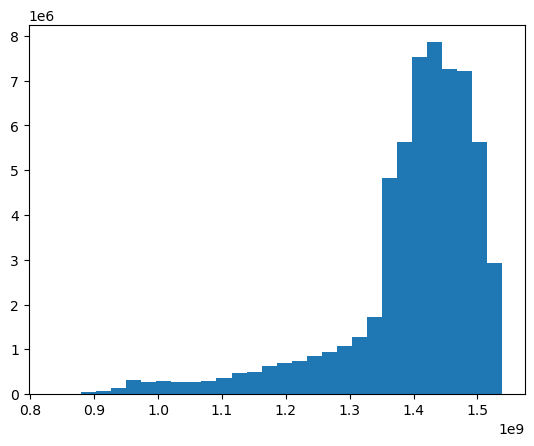

In [14]:
plt.hist(time_list, bins=30)

In [47]:
all_data = new_data_A + new_data_B
# new_data, domain_set = filter(all_data, user_minmum=10, item_minimum=10)
#all_data = filter_time(all_data, t_min=1400000000, t_max=1500000000)
all_data = filter_time(all_data)
new_data, domain_set = filter_Kcore(all_data, user_core=5, item_core=3)
final_data, final_domain, user_dict, item_dict, item_count = id_map(new_data, domain_set)
item_count = {domain_id: len(set(domain_set[domain_id]["item"])) for domain_id in domain_set.keys()}
item_dict["item_count"] = item_count

100%|██████████| 60077181/60077181 [00:11<00:00, 5348154.68it/s]


filter time done!


100%|██████████| 225777/225777 [00:00<00:00, 1297168.86it/s]


K-core filter done!


100%|██████████| 225332/225332 [00:00<00:00, 412445.63it/s]


map done!


100%|██████████| 19568/19568 [00:00<00:00, 196925.79it/s]

sort done!


In [48]:
# book和movie两个domain交集的用户数量
len(set(domain_set[0]["user"]) & set(domain_set[1]["user"])), len(set(domain_set[0]["user"])), len(set(domain_set[1]["user"]))

(3896, 18076, 5388)

In [49]:
# domain A中物品数量, domian B中物品数量, 用户数量
len(item_dict[0]["str2id"]), len(item_dict[1]["str2id"]), len(user_dict["str2id"])

(15868, 2852, 19568)

In [50]:
# 验证map是否能对上
print(item_count)
max(item_dict[0]["str2id"].values()), max(item_dict[1]["str2id"].values())

{0: 15868, 1: 2852}


(15868, 2852)

把所有数据先存下来
可以使用final_domain去进行数据筛选

In [51]:
with open("./handled/id_map.json", "w") as f:
    json.dump({"user_dict": user_dict, "item_dict": item_dict}, f)
with open("./handled/amazon_all.pkl", "wb") as f:
    pickle.dump((final_data, final_domain), f)

In [52]:
with open("./handled/id_map.json", "r") as f:
    map_dict = json.load(f)
user_dict = map_dict["user_dict"]
item_dict = map_dict["item_dict"]

with open("./handled/amazon_all.pkl", "rb") as f:
    final_data, final_domain = pickle.load(f)

筛选book-movie两个domain

这里选的是book和movie两个domain

In [53]:
## 先筛选final_data和final_domain
bm_data, bm_domain = {}, {}
for user_id, inter in tqdm(final_domain.items()):
    inter = np.array(inter)
    inter_data = np.array(final_data[user_id])
    bm_data[user_id] = inter_data[np.where(np.logical_or(inter==0, inter == 1))]
    bm_domain[user_id] = inter[np.where(np.logical_or(inter==0, inter == 1))]

  0%|          | 0/19568 [00:00<?, ?it/s]

100%|██████████| 19568/19568 [00:00<00:00, 80720.62it/s]


In [54]:
domain_stats = []
for inter in bm_domain.values():
    domain_stats.append(np.mean(inter))

In [55]:
# 统计两个domain中overlap的用户
domain_stats = np.array(domain_stats)
domain_stats[domain_stats==0].shape[0], domain_stats[domain_stats==1].shape[0], domain_stats.shape[0]

(14180, 1492, 19568)

11.515331152902698


(array([1.5824e+04, 2.4630e+03, 7.4700e+02, 2.6100e+02, 1.1800e+02,
        5.9000e+01, 3.3000e+01, 2.3000e+01, 6.0000e+00, 9.0000e+00,
        6.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  5.        ,  14.76666667,  24.53333333,  34.3       ,
         44.06666667,  53.83333333,  63.6       ,  73.36666667,
         83.13333333,  92.9       , 102.66666667, 112.43333333,
        122.2       , 131.96666667, 141.73333333, 151.5       ,
        161.26666667, 171.03333333, 180.8       , 190.56666667,
        200.33333333, 210.1       , 219.86666667, 229.63333333,
        239.4       , 249.16666667, 258.93333333, 268.7       ,
        278.46666667, 288.23333333, 298.        ]),
 <BarContainer object of 30 artists>)

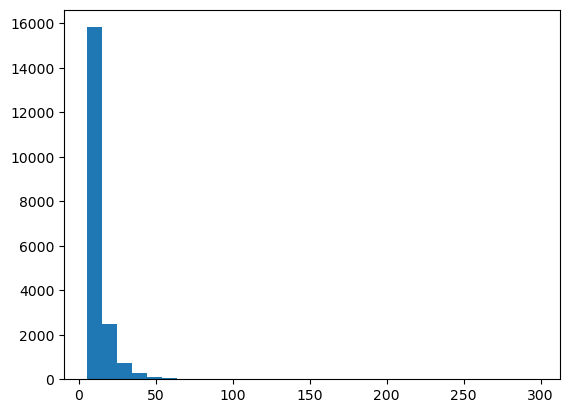

In [57]:
# 统计整体序列的长度
inter_len = []
for inter in bm_data.values():
    inter_len.append(len(inter))
print(np.mean(inter_len))
plt.hist(inter_len, bins=30)

In [58]:
min(inter_len)

5

In [59]:
# 统计物品的交互次数
item_freq = {
        0: np.zeros(item_count[0]+1),
        1: np.zeros(item_count[1]+1),
    }
for user_id in tqdm(final_data.keys()):
    seq = final_data[user_id]
    domain_seq = final_domain[user_id]
    for i in range(len(seq)):
        item_freq[domain_seq[i]][seq[i]] += 1

100%|██████████| 19568/19568 [00:00<00:00, 235200.46it/s]


In [60]:
# 方便画频率分布直方图
item_freq[0][item_freq[0]>30] = 30
item_freq[1][item_freq[1]>30] = 30

In [61]:
np.mean(item_freq[0]), np.mean(item_freq[1])

(9.995714915873716, 9.472134595162986)

(array([1.000e+00, 0.000e+00, 0.000e+00, 4.100e+01, 3.570e+03, 2.381e+03,
        1.598e+03, 1.205e+03, 9.700e+02, 7.770e+02, 6.290e+02, 4.860e+02,
        4.450e+02, 3.570e+02, 2.990e+02, 2.790e+02, 2.240e+02, 2.080e+02,
        1.810e+02, 1.410e+02, 1.520e+02, 1.220e+02, 1.020e+02, 9.300e+01,
        8.600e+01, 8.300e+01, 9.000e+01, 8.400e+01, 6.800e+01, 1.197e+03]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <BarContainer object of 30 artists>)

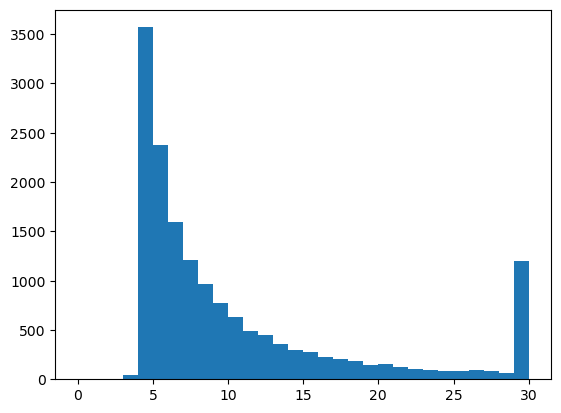

In [62]:
plt.hist(item_freq[0], bins=30)

(array([  1.,   0.,   0.,  11., 703., 436., 311., 183., 166., 129., 137.,
         94.,  71.,  57.,  47.,  54.,  44.,  25.,  33.,  26.,  30.,  25.,
         24.,  15.,  11.,  14.,  13.,   8.,  15., 170.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <BarContainer object of 30 artists>)

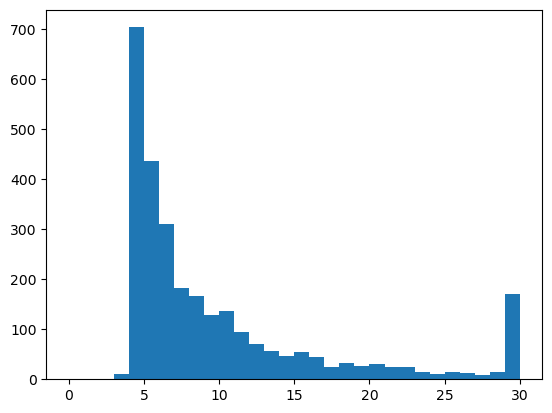

In [63]:
plt.hist(item_freq[1], bins=30)

In [64]:
inter_len = np.array(inter_len)
len(inter_len[inter_len>200]) / len(inter_len)

0.00010220768601798856

In [65]:
with open("./handled/bookandmovie.pkl", "wb") as f:
    pickle.dump((bm_data, bm_domain), f)

In [33]:
# 统计重复交互的问题
# _, i_counts = np.unique(bm_data[0], return_counts=True)
# np.sum(i_counts), len(i_counts)

get attributes

In [66]:
def get_attribute_Amazon(meta_infos, datamaps, attribute_core):

    attributes = defaultdict(int)
    # 做映射
    attribute2id = {}
    id2attribute = {}
    attributeid2num = defaultdict(int)
    attribute_id = 1
    items2attributes = {}
    attribute_lens = []

    for iid, attributes in meta_infos.items():
        item_id = datamaps['item2id'][iid]
        items2attributes[item_id] = []
        for attribute in attributes:
            if attribute not in attribute2id:
                attribute2id[attribute] = attribute_id
                id2attribute[attribute_id] = attribute
                attribute_id += 1
            attributeid2num[attribute2id[attribute]] += 1
            items2attributes[item_id].append(attribute2id[attribute])
        attribute_lens.append(len(items2attributes[item_id]))
    print(f'before delete, attribute num:{len(attribute2id)}')
    print(f'attributes len, Min:{np.min(attribute_lens)}, Max:{np.max(attribute_lens)}, Avg.:{np.mean(attribute_lens):.4f}')
    # 更新datamap
    datamaps['attribute2id'] = attribute2id
    datamaps['id2attribute'] = id2attribute
    datamaps['attributeid2num'] = attributeid2num
    return len(attribute2id), np.mean(attribute_lens), datamaps, items2attributes

In [67]:
from data_process import parse_meta
import json

In [68]:
def Amazon_meta(dataset_name, data_maps):
    datas = {}
    meta_flie = './raw/meta_' + str(dataset_name) + '.json.gz'
    item_asins = list(data_maps['str2id'].keys())
    for info in tqdm(parse_meta(meta_flie)):
        if info['asin'] not in item_asins:
            continue
        datas[info['asin']] = info
    return datas

In [69]:
meta_data_A = Amazon_meta(domain_A, item_dict["0"])
# meta_data_B = Amazon_meta(domain_B, item_dict["1"])

2934949it [16:24, 2982.12it/s]
2934949it [16:24, 2982.11it/s]


In [70]:
len(meta_data_A)

15863

In [71]:
json_str = json.dumps(meta_data_A)
with open("./handled/item2attributes_A.json", 'w') as out:
    out.write(json_str)

In [72]:
meta_data_B = Amazon_meta(domain_B, item_dict["1"])

203766it [00:31, 6494.38it/s]
203766it [00:31, 6493.53it/s]


In [73]:
len(meta_data_B)

2847

In [ ]:
json_str = json.dumps(meta_data_B)
with open("./handled/item2attributes_B.json", 'w') as out:
    out.write(json_str)